# NMV Mixing Density Estimation
## Testing and Visualization of SemiParametricGEstimationGivenMu Algorithm

## 1. Setup and Dependencies

In [1]:
%pip install --quiet tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, gamma, norm, invgamma
from tqdm import tqdm

## 2. Algorithm Implementation

### SemiParametricGEstimationGivenMu Algorithm Implementation

In [3]:
import math
from typing import TypedDict, Unpack
from numpy import _typing
from scipy.integrate import quad_vec
from scipy.special import gamma
from bisect import bisect_left


from src.estimators.estimate_result import EstimateResult

MU_DEFAULT_VALUE = 1
GAMMA_DEFAULT_VALUE = 0.25


def u_sequence_default_value(n: float) -> float:
    """Default sequence for u: n^0.25."""
    return n**0.25


def v_sequence_default_value(n: float) -> float:
    """Default sequence for v: log(n)."""
    return math.log(n)


U_SEQUENCE_DEFAULT_VALUE = u_sequence_default_value
V_SEQUENCE_DEFAULT_VALUE = v_sequence_default_value
X_DATA_DEFAULT_VALUE = [1.0]
GRID_SIZE_DEFAULT_VALUE = 200
INTEGRATION_TOLERANCE_DEFAULT_VALUE = 1e-2
INTEGRATION_LIMIT_DEFAULT_VALUE = 50


class SemiParametricGEstimationGivenMu:
    """Estimation of mixing density function g (xi density function) of NVM mixture represented in canonical form Y =
    alpha + mu*xi + sqrt(xi)*N, where alpha = 0 and mu is given.

    Args:
        sample: sample of the analysed distribution
        params: parameters of the algorithm

    """

    class ParamsAnnotation(TypedDict, total=False):
        mu: float
        gmm: float
        u_value: float
        v_value: float
        x_data: list[float]
        grid_size: int
        integration_tolerance: float
        integration_limit: int

    def __init__(self, sample: _typing.NDArray = None, **kwargs: Unpack[ParamsAnnotation]):
        self.x_powers = None
        self.second_u_integrals = None
        self.first_u_integrals = None
        self.gamma_grid = None
        self.v_grid = None
        self.sample = np.array([]) if sample is None else sample
        self.n = len(self.sample)
        (
            self.mu,
            self.gmm,
            self.u_value,
            self.v_value,
            self.x_data,
            self.grid_size,
            self.integration_tolerance,
            self.integration_limit,
        ) = self._validate_kwargs(self.n, **kwargs)
        self.denominator = 2 * math.pi * self.n
        self.precompute_gamma_grid()
        self.precompute_x_powers()
        self.precompute_u_integrals()

    @staticmethod
    def _validate_kwargs(
        n: int, **kwargs: Unpack[ParamsAnnotation]
    ) -> tuple[float, float, float, float, list[float], int, float, int]:
        mu = kwargs.get("mu", MU_DEFAULT_VALUE)
        gmm = kwargs.get("gmm", GAMMA_DEFAULT_VALUE)
        u_value = kwargs.get("u_value", U_SEQUENCE_DEFAULT_VALUE(n))
        v_value = kwargs.get("v_value", V_SEQUENCE_DEFAULT_VALUE(n))
        x_data = kwargs.get("x_data", X_DATA_DEFAULT_VALUE)
        grid_size = kwargs.get("grid_size", GRID_SIZE_DEFAULT_VALUE)
        integration_tolerance = kwargs.get("integration_tolerance", INTEGRATION_TOLERANCE_DEFAULT_VALUE)
        integration_limit = kwargs.get("integration_limit", INTEGRATION_LIMIT_DEFAULT_VALUE)
        return mu, gmm, u_value, v_value, x_data, grid_size, integration_tolerance, integration_limit

    def conjugate_psi(self, u: float) -> complex:
        return complex((u**2) / 2, self.mu * u)

    def psi(self, u: float) -> complex:
        return complex((u**2) / 2, -self.mu * u)

    def precompute_gamma_grid(self):
        self.v_grid = np.linspace(-self.v_value, self.v_value, self.grid_size)  # Symmetric grid
        gamma_vectorized = np.vectorize(lambda v: gamma(complex(1 - self.gmm, -v)))
        self.gamma_grid = gamma_vectorized(self.v_grid)

    def precompute_x_powers(self):
        """Предвычисляем x^(-gamma - iv) для всех x из x_data и v из v_grid."""
        self.x_powers = {}
        exponents = -self.gmm - 1j * self.v_grid

        for x in self.x_data:
            self.x_powers[x] = np.power(x, exponents)

    def precompute_u_integrals(self):
        self.first_u_integrals = np.zeros((self.grid_size, self.n), dtype=np.complex_)
        self.second_u_integrals = np.zeros((self.grid_size, self.n), dtype=np.complex_)

        for i, v in enumerate(self.v_grid):
            self.first_u_integrals[i] = quad_vec(
                lambda u: self.first_u_integrand(u, v),
                0,
                self.u_value,
                epsabs=self.integration_tolerance,
                limit=self.integration_limit,
            )[0]

            self.second_u_integrals[i] = quad_vec(
                lambda u: self.second_u_integrand(u, v),
                0,
                self.u_value,
                epsabs=self.integration_tolerance,
                limit=self.integration_limit,
            )[0]

    def first_u_integrand(self, u: float, v: float) -> np.ndarray:
        expon_factor = np.exp(-1j * u * self.sample)
        conjugate_psi_factor = self.conjugate_psi(u) ** complex(-self.gmm, -v)
        conjugate_derivative_psi_factor = complex(u, self.mu)
        return expon_factor * conjugate_psi_factor * conjugate_derivative_psi_factor

    @staticmethod
    def find_closest_index(grid: np.ndarray, value: float) -> int:
        idx = bisect_left(grid, value)
        if idx == 0:
            return 0
        if idx == len(grid):
            return len(grid) - 1
        before = grid[idx - 1]
        after = grid[idx]
        return idx - 1 if (value - before) < (after - value) else idx

    def first_v_integrand(self, v: float, x: float) -> np.ndarray:
        idx = self.find_closest_index(self.v_grid, v)
        gamma_val = self.gamma_grid[idx]
        x_power = self.x_powers[x][idx]
        return (self.first_u_integrals[idx] * x_power) / gamma_val

    def second_v_integrand(self, v: float, x: float) -> np.ndarray:
        idx = self.find_closest_index(self.v_grid, v)
        gamma_val = self.gamma_grid[idx]
        x_power = self.x_powers[x][idx]
        return (self.second_u_integrals[idx] * x_power) / gamma_val

    def second_u_integrand(self, u: float, v: float) -> np.ndarray:
        expon_factor = np.exp(1j * u * self.sample)
        psi_factor = self.psi(u) ** complex(-self.gmm, -v)
        derivative_psi_factor = complex(u, -self.mu)
        return expon_factor * psi_factor * derivative_psi_factor

    def compute_integrals_for_x(self, x: float) -> float:
        first_integral = quad_vec(
            lambda v: self.first_v_integrand(v, x),
            0,
            self.v_value,
            epsabs=self.integration_tolerance,
            limit=self.integration_limit,
        )[0]
        second_integral = quad_vec(
            lambda v: self.second_v_integrand(v, x),
            -self.v_value,
            0,
            epsabs=self.integration_tolerance,
            limit=self.integration_limit,
        )[0]
        total = np.sum(first_integral + second_integral) / self.denominator
        return max(0.0, total.real)

    def algorithm(self, sample: np._typing.NDArray) -> EstimateResult:
        """Optimized estimation of g for given mu."""
        y_data = [self.compute_integrals_for_x(x) for x in self.x_data]
        return EstimateResult(list_value=y_data, success=True)

### Mu Estimation Algorithm Implementation


In [36]:
from typing import Callable, Optional, TypedDict, Unpack

import mpmath
import numpy as np
from numpy import _typing

from src.estimators.estimate_result import EstimateResult

M_DEFAULT_VALUE = 1000
TOLERANCE_DEFAULT_VALUE = 10**-5
OMEGA_DEFAULT_VALUE = lambda x: -1 * math.sin(x) if abs(x) <= math.pi else 0
MAX_ITERATIONS_DEFAULT_VALUE = 10**9
PARAMETER_KEYS = ["m", "tolerance", "omega", "max_iterations"]


class SemiParametricMuEstimation:
    """Estimation of mu parameter of NVM mixture represented in canonical form Y = alpha + mu*xi + sqrt(xi)*N,
    where alpha = 0

    Args:
        sample: sample of the analysed distribution
        params: parameters of the algorithm
                m - search area,
                tolerance - defines where to stop binary search,
                omega - Lipschitz continuous odd function on R with compact support

    """

    class ParamsAnnotation(TypedDict, total=False):
        """Class for parameters annotation"""

        m: float
        tolerance: float
        omega: Callable[[float], float]
        max_iterations: float

    def __init__(self, sample: Optional[_typing.ArrayLike] = None, **kwargs: Unpack[ParamsAnnotation]):
        self.sample = np.array([]) if sample is None else sample
        self.m, self.tolerance, self.omega, self.max_iterations = self._validate_kwargs(**kwargs)

    @staticmethod
    def _validate_kwargs(**kwargs: Unpack[ParamsAnnotation]) -> tuple[float, float, Callable[[float], float], float]:
        """Parameters validation function

        Args:
            kwargs: Parameters of Algorithm

        Returns: Parameters of Algorithm

        """
        if any([i not in PARAMETER_KEYS for i in kwargs]):
            raise ValueError("Got unexpected parameter")
        m = kwargs.get("m", M_DEFAULT_VALUE)
        tolerance = kwargs.get("tolerance", TOLERANCE_DEFAULT_VALUE)
        omega = kwargs.get("omega", OMEGA_DEFAULT_VALUE)
        max_iterations = kwargs.get("max_iterations", MAX_ITERATIONS_DEFAULT_VALUE)
        if not isinstance(m, int) or m <= 0:
            raise ValueError("Expected positive integer as parameter m")
        if not isinstance(tolerance, (int, float)) or tolerance <= 0:
            raise ValueError("Expected positive float as parameter tolerance")
        if not callable(omega):
            raise ValueError("Expected callable object as parameter omega")
        if not isinstance(max_iterations, int) or max_iterations <= 0:
            raise ValueError("Expected positive integer as parameter max_iterations")
        return m, tolerance, omega, max_iterations

    def __w(self, p: float, sample: np._typing.NDArray) -> float:
        """Root of this function is an estimation of mu

        Args:
            p: float
            sample: sample of the analysed distribution

        Returns: function value

        """
        y = 0.0
        for x in sample:
            try:
                e = math.exp(-p * x)
            except OverflowError:
                e = mpmath.exp(-p * x)
            y += e * self.omega(x)
        return y

    def algorithm(self, sample: np._typing.NDArray) -> EstimateResult:
        """Root of this function is an estimation of mu

        Args:
            sample: sample of the analysed distribution

        Returns: estimated mu value

        """
        if self.__w(0, sample) == 0:
            return EstimateResult(value=0, success=True)
        if self.__w(0, sample) > 0:
            second_result = self.algorithm(-1 * sample)
            return EstimateResult(value=-1 * second_result.value, success=second_result.success)
        if self.__w(self.m, sample) < 0:
            return EstimateResult(value=self.m, success=False)

        left, right = 0.0, self.m
        iteration = 0
        while left <= right:
            mid = (right + left) / 2
            if iteration > self.max_iterations:
                return EstimateResult(value=mid, success=False)
            iteration += 1
            if abs(self.__w(mid, sample)) < self.tolerance:
                return EstimateResult(value=mid, success=True)
            elif self.__w(mid, sample) < 0:
                left = mid
            else:
                right = mid
        return EstimateResult(value=-1, success=False)

## 3. Test Data Generation

In [ ]:
from scipy.stats import gamma as gamma_dist


def generate_test_data(distribution, params, n=1000, mu=1):
    """
    Generates test samples from different mixing distributions.

    Parameters:
    - distribution: str, name of the mixing distribution ('exponential', 'gamma', 'invgamma')
    - params: dict, parameters for the distribution
    - n: int, sample size
    - mu: float, mean parameter for the normal variance-mean mixture

    Returns:
    - sample: np.ndarray, generated mixture samples
    - true_g: callable, true mixing density function
    """
    if distribution == "exponential":
        xi = expon(scale=params["scale"]).rvs(n)
        true_g = lambda x: expon(scale=params["scale"]).pdf(x)
    elif distribution == "gamma":
        xi = gamma_dist(a=params["shape"], scale=params["scale"]).rvs(n)
        true_g = lambda x: gamma_dist.pdf(x, a=params["shape"], scale=params["scale"])
    elif distribution == "invgamma":
        xi = invgamma(a=params["shape"], scale=params["scale"]).rvs(n)
        true_g = lambda x: invgamma.pdf(x, a=params["shape"], scale=params["scale"])
    else:
        raise ValueError(f"Unknown distribution: {distribution}")

    sample = mu * xi + np.sqrt(xi) * norm().rvs(n)
    return sample, true_g

## 4. Visualization Functions

In [5]:
def plot_results(x_values, estimates, true_density, title):
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, estimates, "bo-", label="Estimated Density")
    plt.plot(x_values, true_density(x_values), "r--", label="True Density")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_error_analysis(sample_sizes, errors):
    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, errors, "mo-")
    plt.title("Estimation Error vs Sample Size")
    plt.xlabel("Sample Size")
    plt.ylabel("MSE")
    plt.xscale("log")
    plt.yscale("log")
    plt.grid(True)
    plt.show()

## Metrics

In [ ]:
import numpy as np
from scipy.special import rel_entr


def calculate_metrics(true_g, predicted_values, x_values):
    true_values = true_g(x_values)

    # MSE
    mse = np.mean((predicted_values - true_values) ** 2)

    # MAE
    mae = np.mean(np.abs(predicted_values - true_values))

    # R-squared
    ss_total = np.sum((true_values - np.mean(true_values)) ** 2)
    ss_residual = np.sum((true_values - predicted_values) ** 2)
    r_squared = 1 - (ss_residual / ss_total)

    # KL-дивергенция
    kl_divergence = np.sum(rel_entr(true_values, predicted_values))

    # Max Error
    max_error = np.max(np.abs(predicted_values - true_values))

    return {"MSE": mse, "MAE": mae, "R-squared": r_squared, "KL Divergence": kl_divergence, "Max Error": max_error}

## 5. Examples

### Example 1: Basic Functionality Test

#### Exponential

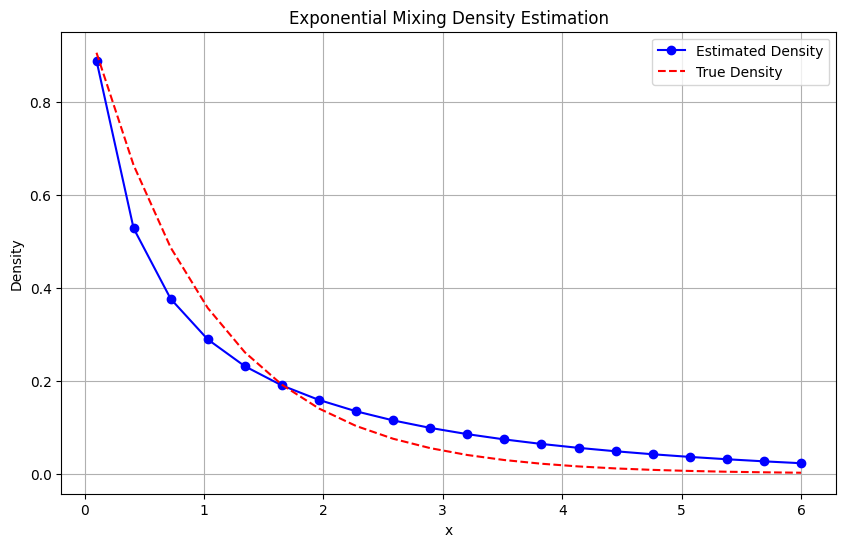

In [ ]:
sample, true_g = generate_test_data("exponential", {"scale": 1}, n=500)

x_values = np.linspace(0.1, 6, 20)
estimator = SemiParametricGEstimationGivenMu(sample, mu=1, x_data=x_values, u_value=7.6, v_value=0.9, grid_size=200)

result = estimator.algorithm(sample)

plot_results(x_values, result.list_value, true_g, "Exponential Mixing Density Estimation")

#### Gamma

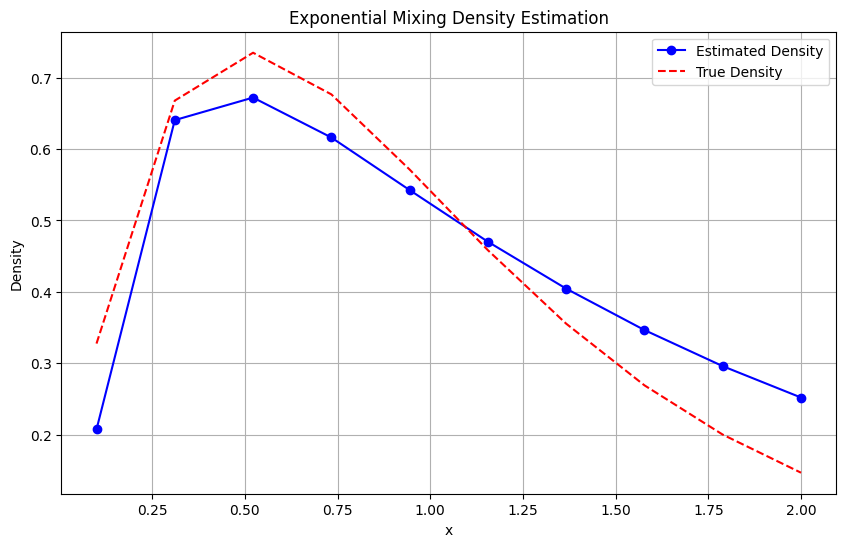

In [ ]:
sample, true_g = generate_test_data("gamma", {"shape": 2, "scale": 0.5}, n=2000)

x_values = np.linspace(0.1, 2, 10)
estimator = SemiParametricGEstimationGivenMu(sample, mu=1, x_data=x_values, u_value=7.6, v_value=1.82, grid_size=400)

result = estimator.algorithm(sample)

plot_results(x_values, result.list_value, true_g, "Exponential Mixing Density Estimation")

In [ ]:
metrics = calculate_metrics(true_g, result.list_value, x_values)

print("Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

Metrics:
MSE: 0.0053
MAE: 0.0639
R-squared: 0.8705
KL Divergence: 0.0529
Max Error: 0.1203


#### Inverse Gamma

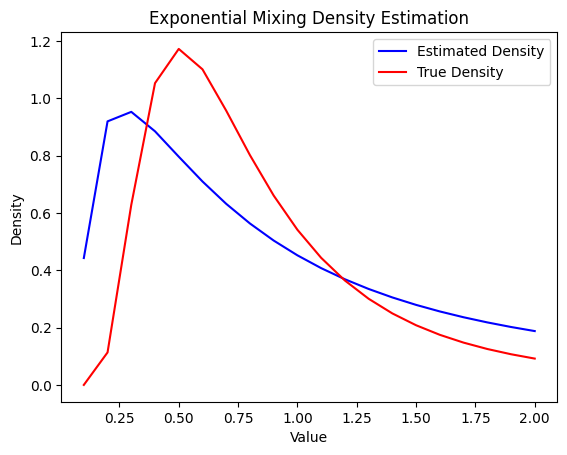

Metrics:
MSE: 0.0760
MAE: 0.1986
R-squared: 0.4438
KL Divergence: 1.1266
Max Error: 0.8060


In [ ]:
sample, true_g = generate_test_data("invgamma", {"shape": 3, "scale": 2}, n=500)

x_values = np.linspace(0.1, 2, 20)
estimator = SemiParametricGEstimationGivenMu(sample, mu=1, x_data=x_values, u_value=7.6, v_value=1.82)

result = estimator.algorithm(sample)

plot_results(x_values, result.list_value, true_g, "Exponential Mixing Density Estimation")
metrics = calculate_metrics(true_g, result.list_value, x_values)

print("Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

### Example 2: Parameter Sensitivity Analysis

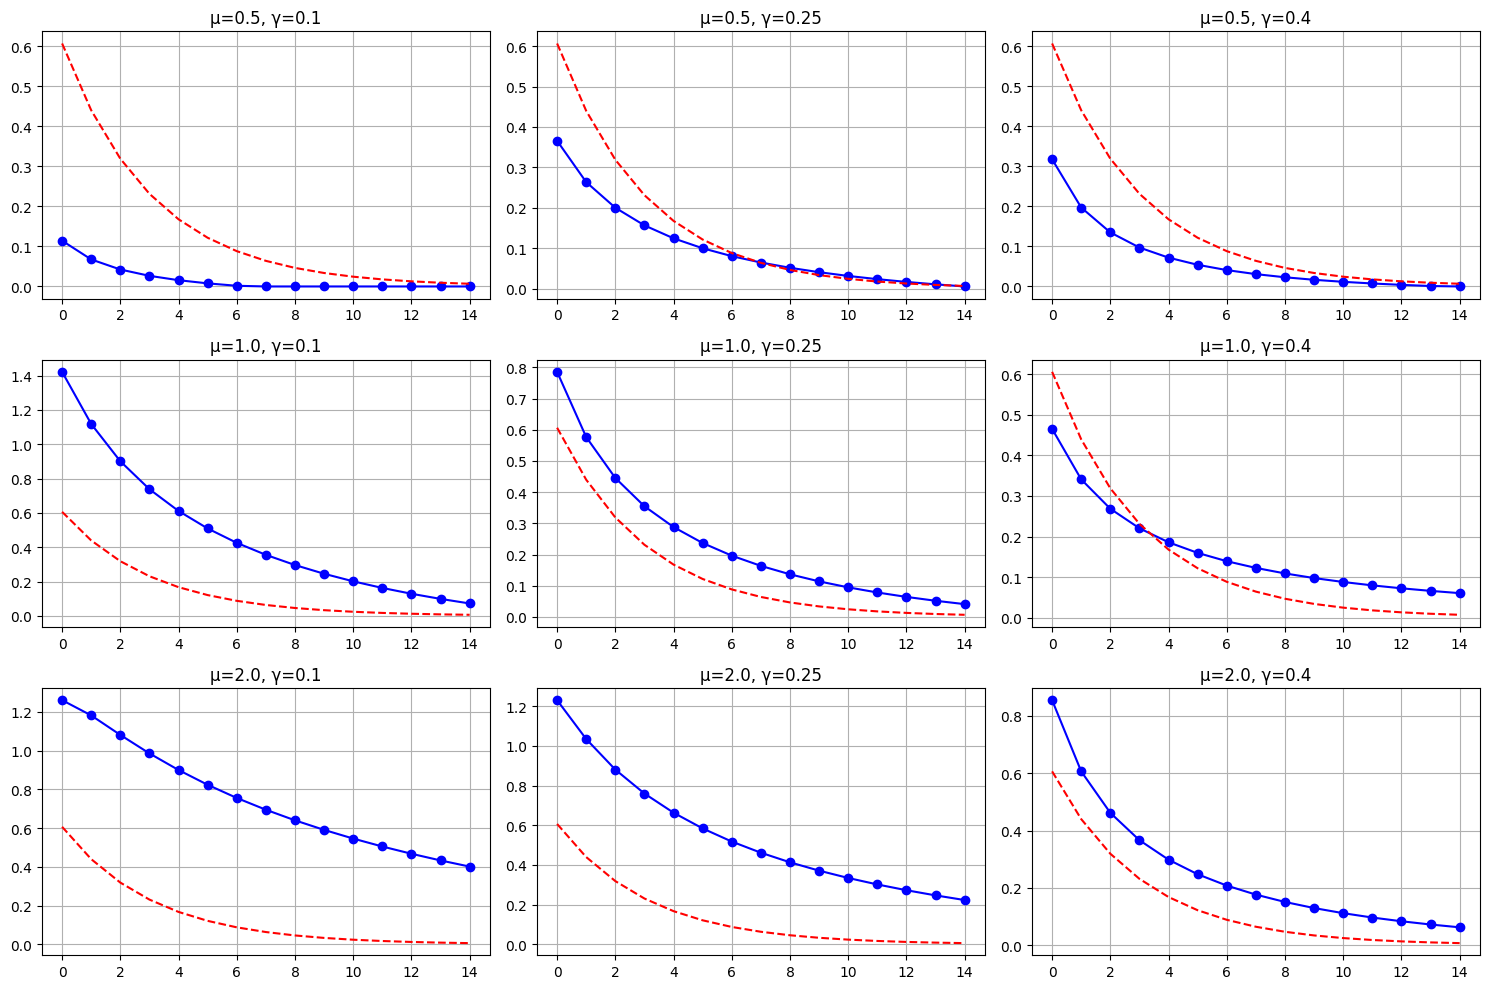

In [103]:
mu_values = [0.5, 1.0, 2.0]
gamma_values = [0.1, 0.25, 0.4]

fig, axes = plt.subplots(len(mu_values), len(gamma_values), figsize=(15, 10))

for i, mu in enumerate(mu_values):
    for j, gmm in enumerate(gamma_values):
        sample, true_g = generate_test_data("exponential", {"scale": 1}, n=100)

        estimator = SemiParametricGEstimationGivenMu(
            sample, mu=mu, gmm=gmm, x_data=np.linspace(0.5, 5, 15), u_value=7.6, v_value=0.9
        )

        result = estimator.algorithm(sample)

        ax = axes[i, j]
        ax.plot(result.list_value, "bo-", label="Estimated")
        ax.plot(true_g(np.linspace(0.5, 5, 15)), "r--", label="True")
        ax.set_title(f"μ={mu}, γ={gmm}")
        ax.grid(True)

plt.tight_layout()
plt.show()

## Bimodal Mixing Density Distribution


In [ ]:
def generate_multimodal_xi(n: int, shape1: float, scale1: float, shape2: float, scale2: float, weight: float = 0.5):
    xi1 = gamma_dist(a=shape1, scale=scale1).rvs(int(n * weight))
    xi2 = gamma_dist(a=shape2, scale=scale2).rvs(int(n * (1 - weight)))
    return np.concatenate([xi1, xi2])

In [ ]:
def generate_test_data_multimodal(
    n: int, shape1: float, scale1: float, shape2: float, scale2: float, weight: float = 0.5, mu: float = 1
):
    xi = generate_multimodal_xi(n, shape1, scale1, shape2, scale2, weight)

    def true_g(x):
        return weight * gamma_dist.pdf(x, a=shape1, scale=scale1) + (1 - weight) * gamma_dist.pdf(
            x, a=shape2, scale=scale2
        )

    sample = mu * xi + np.sqrt(xi) * norm().rvs(n)
    return sample, true_g

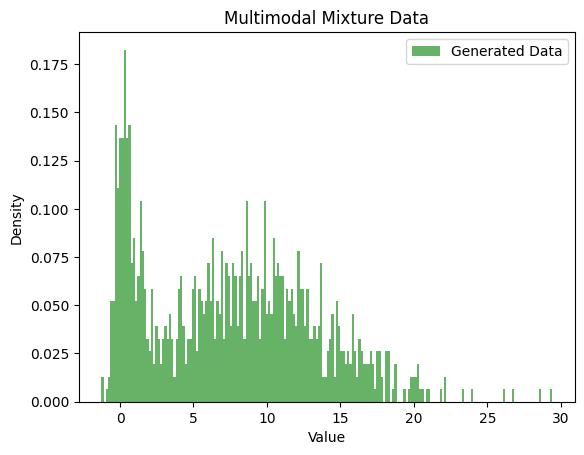

In [ ]:
n = 1000
shape1, scale1 = 1, 1
shape2, scale2 = 10, 1
weight = 0.3
mu = 1

sample, true_g = generate_test_data_multimodal(n, shape1, scale1, shape2, scale2, weight, mu)

plt.hist(sample, bins=200, density=True, alpha=0.6, color="g", label="Generated Data")
plt.title("Multimodal Mixture Data")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

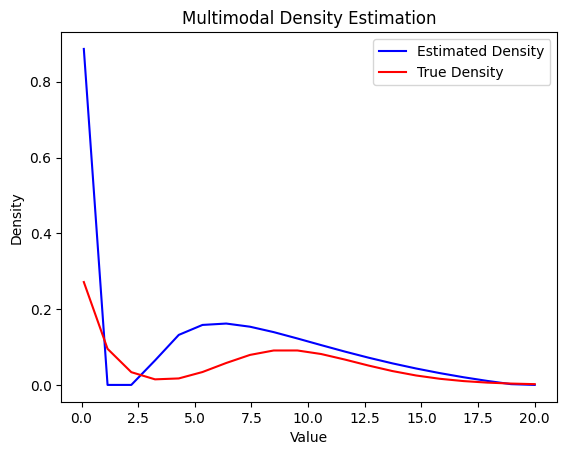

Metrics:
MSE: 0.0221
MAE: 0.0714
R-squared: -5.4012
KL Divergence: inf
Max Error: 0.6151


In [ ]:
x_values = np.linspace(0.1, 20, 20)
estimator = SemiParametricGEstimationGivenMu(sample, mu=mu, x_data=x_values, u_value=7.6, v_value=2, grid_size=100)

result = estimator.algorithm(sample)


def plot_results(x_values, predicted_values, true_g, title):
    plt.plot(x_values, predicted_values, "b-", label="Estimated Density")
    plt.plot(x_values, true_g(x_values), "r-", label="True Density")
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


plot_results(x_values, result.list_value, true_g, "Multimodal Density Estimation")

metrics = calculate_metrics(true_g, result.list_value, x_values)

print("Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

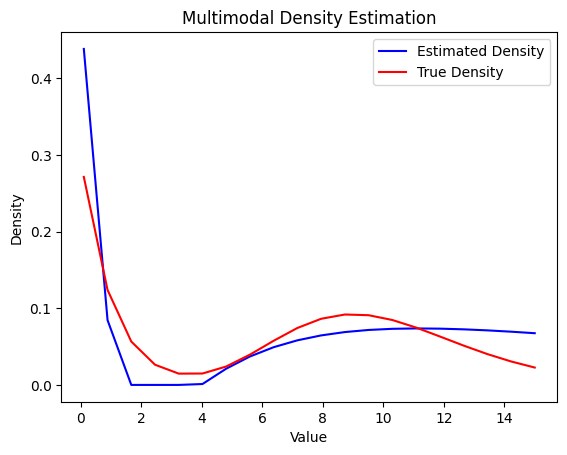

Metrics:
MSE: 0.0020
MAE: 0.0285
R-squared: 0.3362
KL Divergence: inf
Max Error: 0.1670


In [ ]:
x_values = np.linspace(0.1, 15, 20)
estimator = SemiParametricGEstimationGivenMu(sample, mu=mu, x_data=x_values, u_value=5.6, v_value=1.8, grid_size=100)

result = estimator.algorithm(sample)


def plot_results(x_values, predicted_values, true_g, title):
    plt.plot(x_values, predicted_values, "b-", label="Estimated Density")
    plt.plot(x_values, true_g(x_values), "r-", label="True Density")
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


plot_results(x_values, result.list_value, true_g, "Multimodal Density Estimation")

metrics = calculate_metrics(true_g, result.list_value, x_values)

print("Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

##  Bootstrap Confidence Intervals Analysis

In [ ]:
import numpy as np


def bootstrap_confidence_intervals(sample, estimator, x_values, n_bootstrap=100, alpha=0.05):
    bootstrap_estimates = []

    for _ in tqdm(range(n_bootstrap)):
        resample = np.random.choice(sample, size=len(sample), replace=True)

        estimator_resample = SemiParametricGEstimationGivenMu(
            resample, mu=estimator.mu, x_data=x_values, u_value=estimator.u_value, v_value=estimator.v_value
        )
        result = estimator_resample.algorithm(resample)
        bootstrap_estimates.append(result.list_value)

    ci_lower = np.percentile(bootstrap_estimates, 100 * alpha / 2, axis=0)
    ci_upper = np.percentile(bootstrap_estimates, 100 * (1 - alpha / 2), axis=0)

    return ci_lower, ci_upper

100%|██████████| 20/20 [05:41<00:00, 17.07s/it]


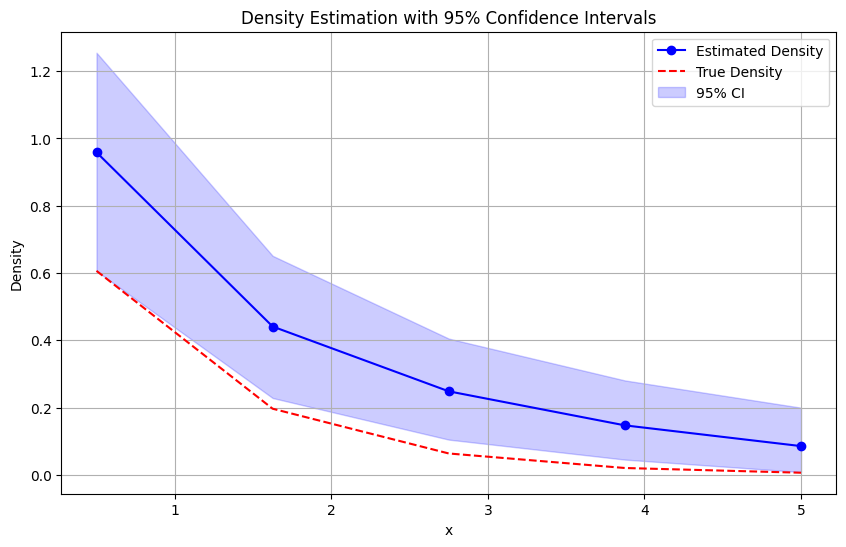

In [ ]:
sample, true_g = generate_test_data("exponential", {"scale": 1}, n=100)
x_values = np.linspace(0.5, 5, 5)

estimator_given_mu = SemiParametricGEstimationGivenMu(sample, mu=1, x_data=x_values, u_value=7.6, v_value=0.9)

result_given_mu = estimator_given_mu.algorithm(sample)

ci_lower, ci_upper = bootstrap_confidence_intervals(sample, estimator_given_mu, x_values, n_bootstrap=20)

plt.figure(figsize=(10, 6))
plt.plot(x_values, result_given_mu.list_value, "bo-", label="Estimated Density")
plt.plot(x_values, true_g(x_values), "r--", label="True Density")
plt.fill_between(x_values, ci_lower, ci_upper, color="blue", alpha=0.2, label="95% CI")
plt.title("Density Estimation with 95% Confidence Intervals")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 10/10 [07:12<00:00, 43.28s/it]


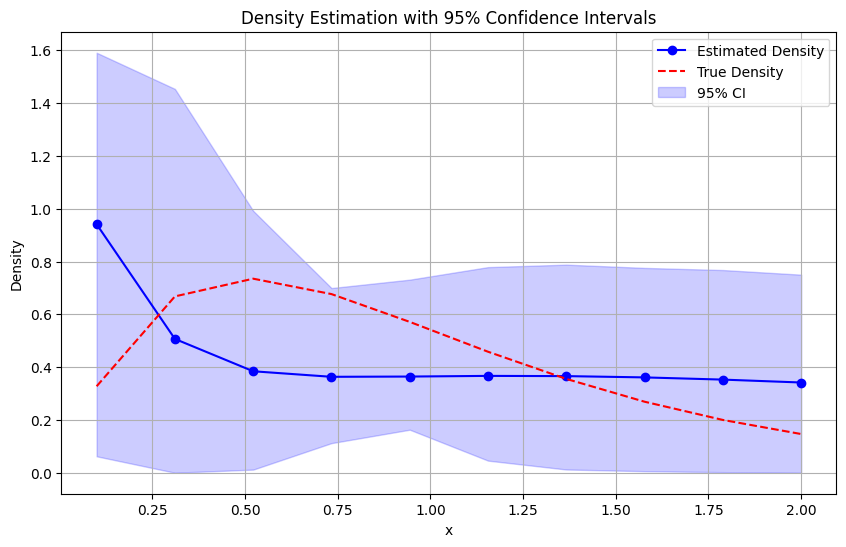

In [ ]:
sample, true_g = generate_test_data("gamma", {"shape": 2, "scale": 0.5}, n=500)

x_values = np.linspace(0.1, 2, 10)
estimator = SemiParametricGEstimationGivenMu(sample, mu=1, x_data=x_values, u_value=7.6, v_value=1.82, grid_size=400)

result_given_mu = estimator.algorithm(sample)

ci_lower, ci_upper = bootstrap_confidence_intervals(sample, estimator, x_values, n_bootstrap=10)

plt.figure(figsize=(10, 6))
plt.plot(x_values, result_given_mu.list_value, "bo-", label="Estimated Density")
plt.plot(x_values, true_g(x_values), "r--", label="True Density")
plt.fill_between(x_values, ci_lower, ci_upper, color="blue", alpha=0.2, label="95% CI")
plt.title("Density Estimation with 95% Confidence Intervals")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 10/10 [05:40<00:00, 34.03s/it]


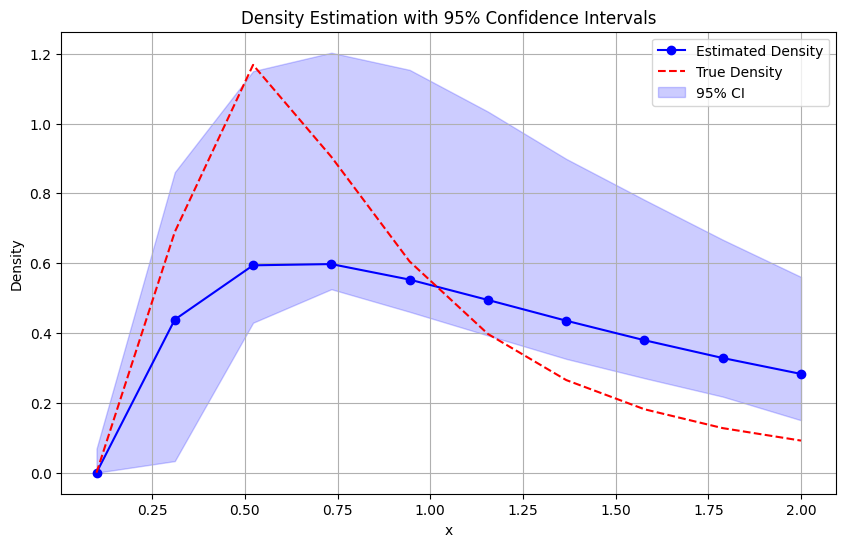

In [ ]:
sample, true_g = generate_test_data("invgamma", {"shape": 3, "scale": 2}, n=500)

x_values = np.linspace(0.1, 2, 10)
estimator = SemiParametricGEstimationGivenMu(sample, mu=1, x_data=x_values, u_value=7.6, v_value=1.82, grid_size=100)

result_given_mu = estimator.algorithm(sample)

ci_lower, ci_upper = bootstrap_confidence_intervals(sample, estimator, x_values, n_bootstrap=10)

plt.figure(figsize=(10, 6))
plt.plot(x_values, result_given_mu.list_value, "bo-", label="Estimated Density")
plt.plot(x_values, true_g(x_values), "r--", label="True Density")
plt.fill_between(x_values, ci_lower, ci_upper, color="blue", alpha=0.2, label="95% CI")
plt.title("Density Estimation with 95% Confidence Intervals")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()